# Imports

In [ ]:
# %pip install pandas numpy matplotlib seaborn scikit-learn xgboost
# %pip freeze > requirements.txt
# pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('Dados/desafio_indicium_imdb.csv', index_col=0)
df_top_movies = pd.read_csv('Dados/top_year_movies.csv')
df.rename(columns={'Series_Title': 'title'}, inplace=True)
df = pd.merge(df, df_top_movies, on='title', how='outer')

In [3]:
df = df.drop(columns=['rating_imdb'])

target = 'IMDB_Rating'
df = df.dropna(subset=[target])

In [4]:
df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=False).astype(int)
df['Runtime'].head()

21      95
71      96
79     134
117    119
147    149
Name: Runtime, dtype: int64

In [5]:
df['Released_Year'] = pd.to_numeric(df['Released_Year'].str.replace(',', '', regex=False), errors='coerce')
df['Released_Year'].head()

21     2009.0
71     1957.0
79     2013.0
117    2019.0
147    1968.0
Name: Released_Year, dtype: float64

In [6]:
df['Gross'] = pd.to_numeric(df['Gross'].str.replace(',', '', regex=False), errors='coerce')
df['Gross'].head()

21      32391374.0
71       4360000.0
79      56671993.0
117    159227644.0
147     56954992.0
Name: Gross, dtype: float64

In [7]:
certificate_map = {
    'G': 'General Audience (All Ages)',
    'PG': 'Parental Guidance Suggested',
    'PG-13': 'Parents Strongly Cautioned (13+)',
    'R': 'Restricted (17+)',
    'U': 'General Audience (All Ages)',
    'UA': 'Parental Guidance Suggested',
    'U/A': 'Parental Guidance Suggested',
    'TV-MA': 'Restricted (17+)',
    'TV-PG': 'Parental Guidance Suggested',
    'TV-14': 'Parents Strongly Cautioned (13+)',
    'GP': 'Parental Guidance Suggested',
    'Passed': 'Unrated / Not Classified',
    'Approved': 'Unrated / Not Classified',
    'Unrated': 'Unrated / Not Classified',
    '16': 'Parents Strongly Cautioned (13+)',
    np.nan: 'Unrated / Not Classified'
}

# Aplicar o mapeamento
df['Certificate'] = df['Certificate'].map(certificate_map).fillna('Unrated / Not Classified')

# Verificar valores únicos padronizados
print(df['Certificate'].unique())


['Parental Guidance Suggested' 'General Audience (All Ages)'
 'Unrated / Not Classified' 'Restricted (17+)'
 'Parents Strongly Cautioned (13+)']


# EDA

## Geral

In [8]:
df.head(2)

,title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,id,link,year,duration,rating_mpa,vote,budget,gross_world_wide,gross_us_canada,gross_opening_weekend,director,writer,star,genre,country_origin,filming_location,production_company,language,win,nomination,oscar
21,(500) Days of Summer,2009.0,Parental Guidance Suggested,95,"Comedy, Drama, Romance",7.7,"An offbeat romantic comedy about a woman who doesn't believe true love exists, and the young man who falls for her.",76.0,Marc Webb,Zooey Deschanel,Joseph Gordon-Levitt,Geoffrey Arend,Chloë Grace Moretz,472242.0,32391374.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,12 Angry Men,1957.0,General Audience (All Ages),96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarriage of justice by forcing his colleagues to reconsider the evidence.,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845.0,4360000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.columns

Index(['title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross', 'id', 'link', 'year',
       'duration', 'rating_mpa', 'vote', 'budget', 'gross_world_wide',
       'gross_us_canada', 'gross_opening_weekend', 'director', 'writer',
       'star', 'genre', 'country_origin', 'filming_location',
       'production_company', 'language', 'win', 'nomination', 'oscar'],
      dtype='object')

In [10]:
df.shape

(1104, 36)

In [11]:
df.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,year,vote,budget,gross_world_wide,gross_us_canada,gross_opening_weekend,win,nomination,oscar
count,1103.000000,1104.000000,1104.000000,933.000000,1.104000e+03,9.250000e+02,783.000000,7.830000e+02,6.490000e+02,6.900000e+02,6.520000e+02,5.930000e+02,783.0,783.000000,783.000000
mean,1991.310970,123.132246,7.944203,77.993569,2.747243e+05,7.122691e+07,1996.899106,1.423339e+06,5.165698e+07,1.839053e+08,8.497509e+07,1.763819e+07,0.0,38.754789,0.664112
std,23.061237,29.417196,0.271864,12.337613,3.172512e+05,1.110250e+08,16.551285,4.014217e+06,1.310853e+08,3.214917e+08,1.195147e+08,3.622051e+07,0.0,54.019520,1.377877
min,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03,1960.000000,1.400000e+01,2.000000e+03,3.570000e+02,3.622000e+03,4.320000e+02,0.0,0.000000,0.000000
25%,1977.000000,102.000000,7.700000,70.000000,5.669625e+04,3.969893e+06,1985.000000,6.800000e+04,6.000000e+06,9.966327e+06,6.982804e+06,1.621790e+05,0.0,5.000000,0.000000
50%,1998.000000,119.000000,7.900000,79.000000,1.432500e+05,2.554487e+07,2000.000000,2.140000e+05,1.800000e+07,6.027637e+07,4.095555e+07,1.645502e+06,0.0,19.000000,0.000000
75%,2009.000000,137.000000,8.100000,87.000000,3.793138e+05,9.374000e+07,2010.500000,5.445000e+05,5.200000e+07,2.106674e+08,1.101160e+08,1.982869e+07,0.0,48.500000,1.000000
max,2020.000000,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08,2024.000000,2.600000e+07,2.500000e+09,2.923706e+09,9.366622e+08,3.571150e+08,0.0,382.000000,11.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1104 entries, 21 to 33914
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  1104 non-null   object 
 1   Released_Year          1103 non-null   float64
 2   Certificate            1104 non-null   object 
 3   Runtime                1104 non-null   int64  
 4   Genre                  1104 non-null   object 
 5   IMDB_Rating            1104 non-null   float64
 6   Overview               1104 non-null   object 
 7   Meta_score             933 non-null    float64
 8   Director               1104 non-null   object 
 9   Star1                  1104 non-null   object 
 10  Star2                  1104 non-null   object 
 11  Star3                  1104 non-null   object 
 12  Star4                  1104 non-null   object 
 13  No_of_Votes            1104 non-null   float64
 14  Gross                  925 non-null    float64
 15  id     

## Hipoteses

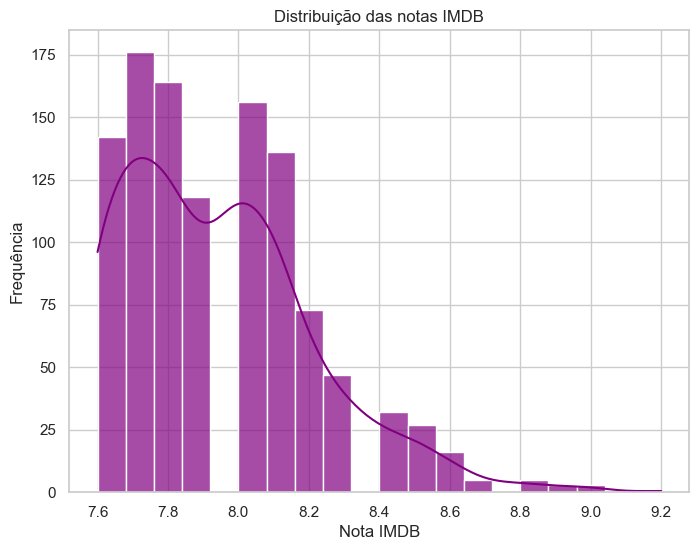

In [46]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,6))
sns.histplot(df['IMDB_Rating'], bins=20, kde=True, color='purple',alpha=0.7)
plt.title('Distribuição das notas IMDB')
plt.xlabel('Nota IMDB')
plt.ylabel('Frequência')
plt.show()

Filmes produzidos em algum pais especifico sao mais bem avaliados?

C:\Users\michi\AppData\Local\Temp\ipykernel_25464\1163721315.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


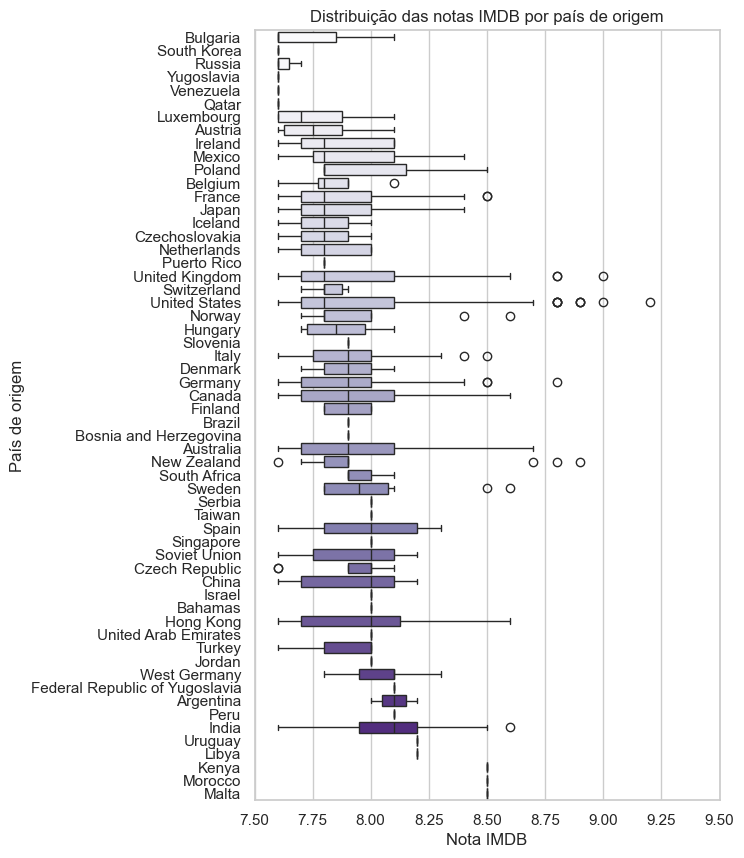

In [67]:
# Separar países em múltiplas linhas
df_exploded = df.assign(
    country_origin=df["country_origin"].str.split(", ")
).explode("country_origin").reset_index(drop=True)

plt.figure(figsize=(6,10))
sns.boxplot(
    data=df_exploded,
    x="IMDB_Rating",
    y="country_origin",
    order=df_exploded.groupby("country_origin")["IMDB_Rating"].median().sort_values().index,
    palette="Purples"
)

plt.title("Distribuição das notas IMDB por país de origem")
plt.xlabel("Nota IMDB")
plt.ylabel("País de origem")
plt.xlim(7.5, 9.5)
plt.show()


Filmes em alghum idioma espeficico sao mais bem avaliados? 

C:\Users\michi\AppData\Local\Temp\ipykernel_25464\2546516048.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


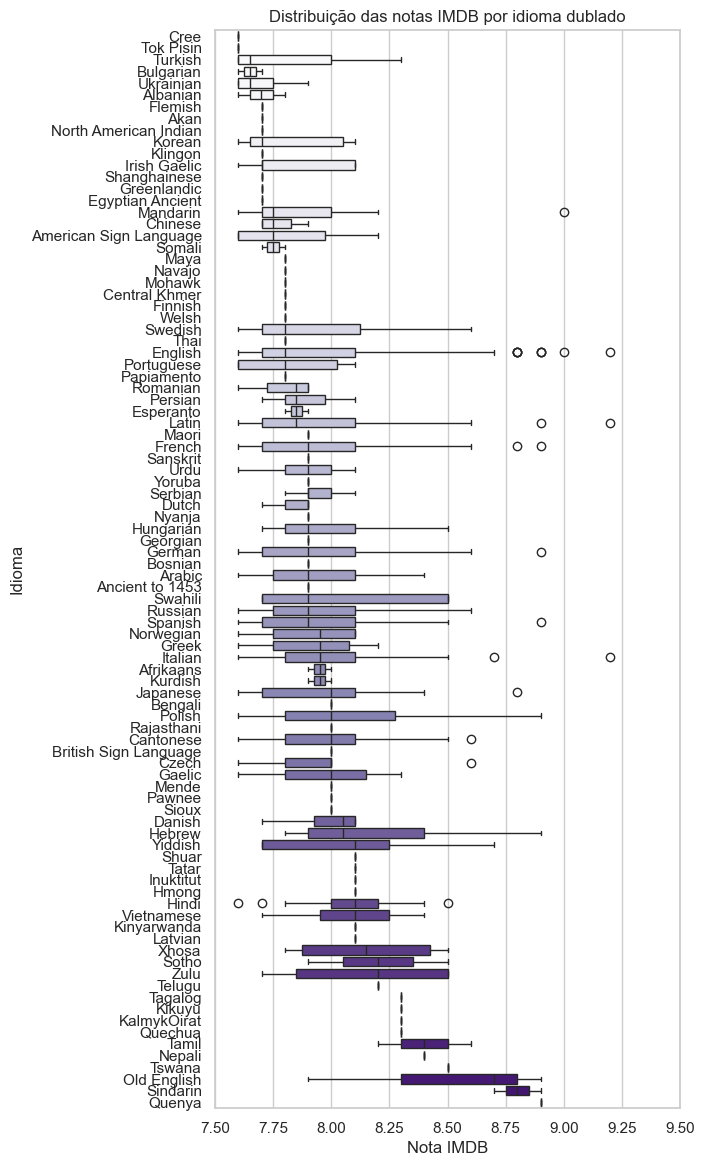

In [ ]:
# Separar idiomas em múltiplas linhas
df_exploded = df.assign(
    language=df["language"].str.split(", ")
).explode("language").reset_index(drop=True)

plt.figure(figsize=(6,14))
sns.boxplot(
    data=df_exploded,
    x="IMDB_Rating",
    y="language",
    order=df_exploded.groupby("language")["IMDB_Rating"].median().sort_values().index,
    palette="Purples"
)

plt.title("Distribuição das notas IMDB por idioma dublado")
plt.xlabel("Nota IMDB")
plt.ylabel("Idioma")
plt.xlim(7.5, 9.5)
plt.show()

Alguma classificacao indicativa é melhor avaliada?

C:\Users\michi\AppData\Local\Temp\ipykernel_25464\1186281021.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


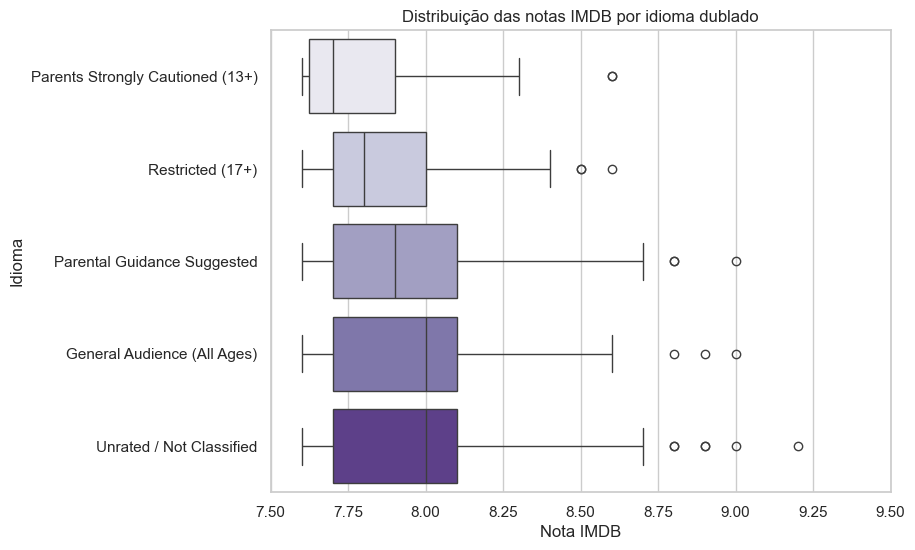

In [74]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df,
    x="IMDB_Rating",
    y="Certificate",
    order=df.groupby("Certificate")["IMDB_Rating"].median().sort_values().index,
    palette="Purples"
)

plt.title("Distribuição das notas IMDB por idioma dublado")
plt.xlabel("Nota IMDB")
plt.ylabel("Idioma")
plt.xlim(7.5, 9.5)
plt.show()


Filmes com mais votos (No_of_Votes) tendem a ter nota mais alta?

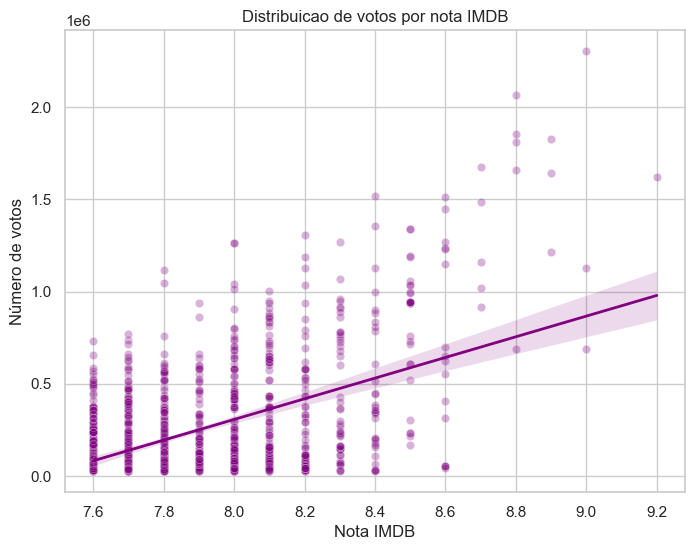

In [39]:
plt.figure(figsize=(8,6))

# Scatter
sns.scatterplot(
    data=df, 
    x='IMDB_Rating', 
    y='No_of_Votes', 
    alpha=0.3, 
    color='purple'
)
# Linha de tendência
sns.regplot(
    data=df,
    x='IMDB_Rating',
    y='No_of_Votes',
    scatter=False,   # evita duplicar pontos
    color='purple',   # cor da linha
    line_kws={"lw":2} # espessura
)

plt.title('Distribuicao de votos por nota IMDB')
plt.xlabel('Nota IMDB')
plt.ylabel('Número de votos')
plt.show()


Filmes com maior Meta_score tendem a ter nota maior no IMDB?

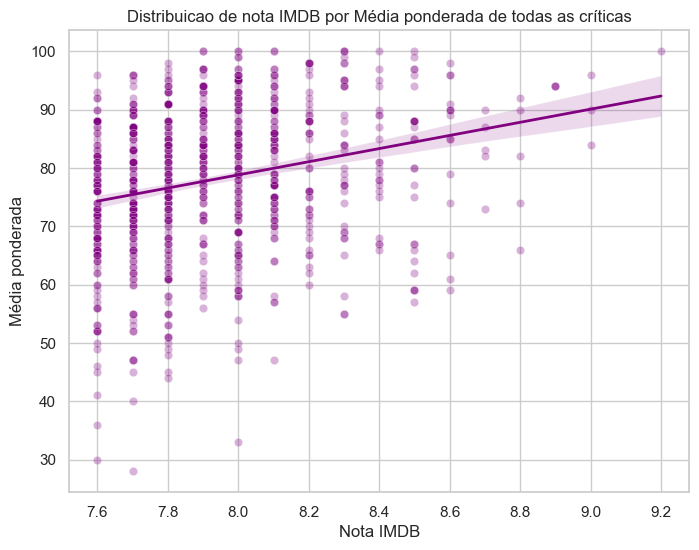

In [41]:
plt.figure(figsize=(8,6))

# Scatter
sns.scatterplot(
    data=df, 
    x='IMDB_Rating', 
    y='Meta_score', 
    alpha=0.3, 
    color='purple'
)

# Linha de tendência
sns.regplot(
    data=df,
    x='IMDB_Rating',
    y='Meta_score',
    scatter=False,   # evita duplicar pontos
    color='purple',   # cor da linha
    line_kws={"lw":2} # espessura
)

plt.title('Distribuicao de nota IMDB por Média ponderada de todas as críticas')
plt.xlabel('Nota IMDB')
plt.ylabel('Média ponderada')
plt.show()

Filmes mais longos (Runtime) podem ter notas maiores?

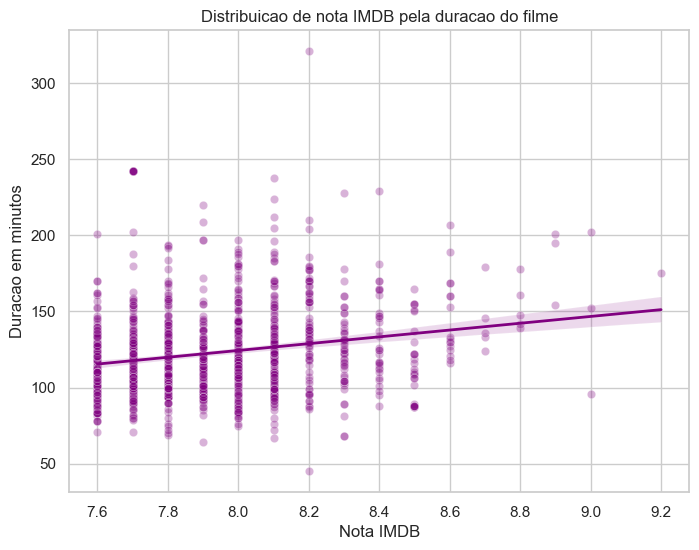

In [42]:
plt.figure(figsize=(8,6))

# Scatter
sns.scatterplot(
    data=df, 
    x='IMDB_Rating', 
    y='Runtime', 
    alpha=0.3, 
    color='purple'
)

# Linha de tendência
sns.regplot(
    data=df,
    x='IMDB_Rating',
    y='Runtime',
    scatter=False,   # evita duplicar pontos
    color='purple',   # cor da linha
    line_kws={"lw":2} # espessura
)

plt.title('Distribuicao de nota IMDB pela duracao do filme')
plt.xlabel('Nota IMDB')
plt.ylabel('Duracao em minutos')
plt.show()

Filmes com maior faturamento tendem a ter maior nota?

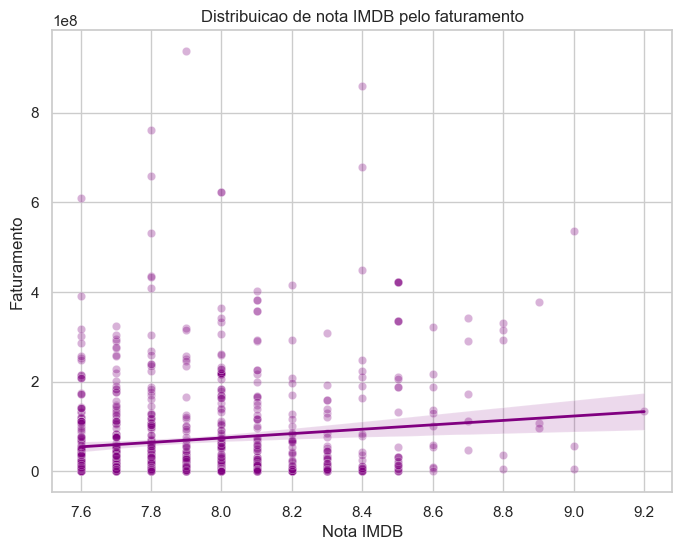

In [43]:
plt.figure(figsize=(8,6))

# Scatter
sns.scatterplot(
    data=df, 
    x='IMDB_Rating', 
    y='Gross', 
    alpha=0.3, 
    color='purple'
)

# Linha de tendência
sns.regplot(
    data=df,
    x='IMDB_Rating',
    y='Gross',
    scatter=False,
    color='purple',
    line_kws={"lw":2}
)

plt.title('Distribuicao de nota IMDB pelo faturamento')
plt.xlabel('Nota IMDB')
plt.ylabel('Faturamento')
plt.show()

Filmes mais recentes tendem a ter notas maiores?

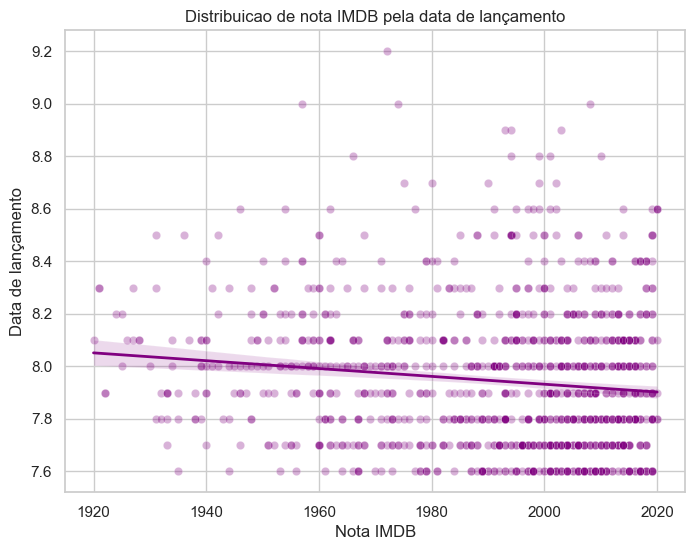

In [45]:
plt.figure(figsize=(8,6))

# Scatter
sns.scatterplot(
    data=df, 
    y='IMDB_Rating', 
    x='Released_Year', 
    alpha=0.3, 
    color='purple'
)

# Linha de tendência
sns.regplot(
    data=df,
    y='IMDB_Rating',
    x='Released_Year',
    scatter=False,
    color='purple',
    line_kws={"lw":2}
)

plt.title('Distribuicao de nota IMDB pela data de lançamento')
plt.xlabel('Nota IMDB')
plt.ylabel('Data de lançamento')
plt.show()

# Modelo IMDB_Rating

In [20]:
X = df.drop(columns=[
    target, 
    'Overview',
    'title',
    'win', 
    'genre', 
    'director', # duplicates
    'id', 
    'year', 
    'link',
    'duration',
    'budget', 
    'gross_world_wide',
    'gross_us_canada', 
    'gross_opening_weekend',
    'star',
    'rating_mpa', 
    'vote', 
    'nomination'
    ])
y = df[target]

X_encoded = X.copy()

# Transformar colunas object em números
for col in X_encoded.select_dtypes(include=['object']).columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))
X = X_encoded.copy()

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

In [21]:
from sklearn.model_selection import GridSearchCV

# Definir grid de hiperparâmetros
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 1],
    "colsample_bytree": [0.7, 0.8, 1]
}

# Criar o modelo
xgb_model = xgb.XGBRegressor(random_state=42)


# Grid search com cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,               # validação cruzada!
    scoring="r2",       # métrica de avaliação
    verbose=1,
    n_jobs=-1       # usar todos os núcleos disponíveis
)

grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor R²:", grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Melhores parâmetros: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Melhor R²: 0.5842267495575312


In [22]:
df[target].min(), df[target].mean(), df[target].median(), df[target].max()

(np.float64(7.6),
 np.float64(7.944202898550724),
 np.float64(7.9),
 np.float64(9.2))

In [23]:
y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_test.shape[1]
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\nAvaliação no conjunto de teste:")
print(f"R²: {r2:.4f}")
print(f"R² Ajustado: {r2_adj:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE (%): {mape:.2f}")



Avaliação no conjunto de teste:
R²: 0.5828
R² Ajustado: 0.5456
MAE: 0.12
MSE: 0.03
RMSE: 0.16
MAPE (%): 1.58


R² para tentarivas de dummyficar o df
- 0.5819 - sem nenhuma dummy 
- 0.5661 - language
- 0.5772 - genero 
- 0.5706 - both dummed

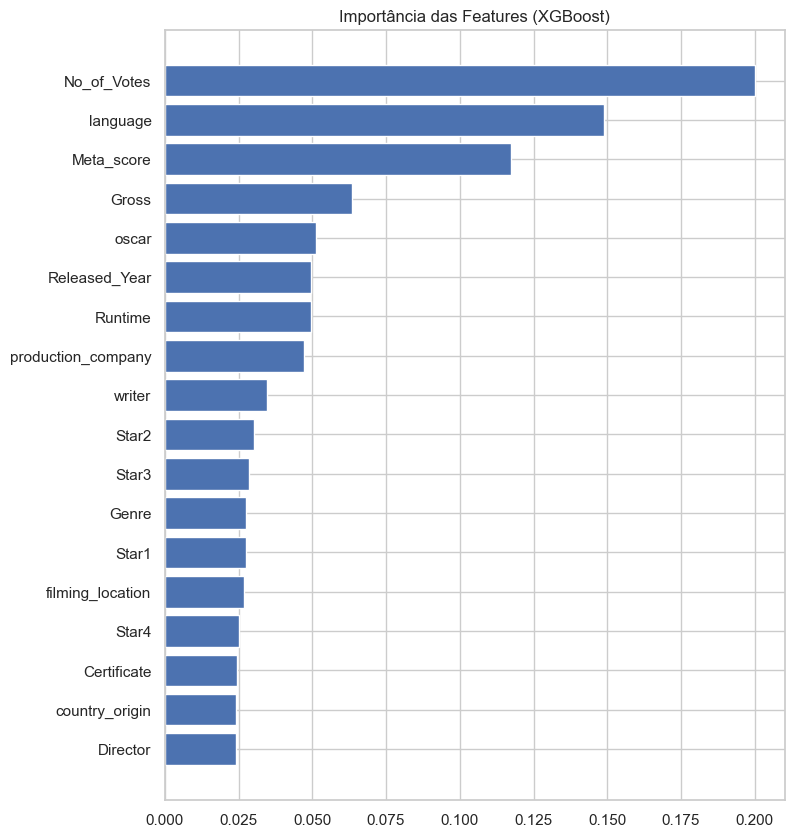

In [24]:
# Fazer previsões
y_pred = grid_search.predict(X_test)

# Pegar o melhor modelo do grid
best_model = grid_search.best_estimator_

# Importâncias das features do melhor modelo
importances = best_model.feature_importances_

# Criar um DataFrame para organizar
feat_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,10))
plt.barh(feat_importances["Feature"], feat_importances["Importance"])
plt.gca().invert_yaxis()
plt.title("Importância das Features (XGBoost)")
plt.show()

In [25]:
import pickle

# Obter o melhor modelo
best_model = grid_search.best_estimator_

# Salvar em um arquivo .pkl
with open("xgboost_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [26]:
X.to_csv('Dados/df_final.csv', index=False)

In [27]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")  

title: ['(500) Days of Summer' '12 Angry Men' '12 Years a Slave' '1917'
 '2001: A Space Odyssey' '21 Grams' '25th Hour' '28 Days Later...'
 '3 Idiots' '300' '3:10 to Yuma' '4 luni, 3 saptamâni si 2 zile' '50/50'
 '8½' 'A Beautiful Mind' 'A Bronx Tale' 'A Christmas Story'
 'A Clockwork Orange' 'A Few Good Men' "A Hard Day's Night"
 'A Little Princess' 'A Man for All Seasons' 'A Night at the Opera'
 'A Star Is Born' 'A Streetcar Named Desire' 'A Wednesday' 'About Time'
 'Abre los ojos' 'Ace in the Hole' 'Adams æbler' 'Adaptation.'
 'After Hours' 'Aguirre, der Zorn Gottes' 'Ah-ga-ssi' 'Airlift'
 'Airplane!' 'Ajeossi' 'Akira' 'Aladdin' 'Alien' 'Aliens' 'All About Eve'
 'All Quiet on the Western Front' 'All That Jazz'
 "All the President's Men" 'Almost Famous' 'Amadeus' 'Amarcord'
 'American Beauty' 'American Gangster' 'American History X'
 'American Psycho' 'Amores perros' 'Amour' 'Amélie' 'Anand'
 'Anatomy of a Murder' 'Andaz Apna Apna' 'Andhadhun' 'Andrei Rublev'
 'Ang-ma-reul bo-at-da' 

In [28]:
df['Gross'].min(), df['Gross'].max()

(np.float64(1305.0), np.float64(936662225.0))

In [29]:
df.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,year,vote,budget,gross_world_wide,gross_us_canada,gross_opening_weekend,win,nomination,oscar
count,1103.000000,1104.000000,1104.000000,933.000000,1.104000e+03,9.250000e+02,783.000000,7.830000e+02,6.490000e+02,6.900000e+02,6.520000e+02,5.930000e+02,783.0,783.000000,783.000000
mean,1991.310970,123.132246,7.944203,77.993569,2.747243e+05,7.122691e+07,1996.899106,1.423339e+06,5.165698e+07,1.839053e+08,8.497509e+07,1.763819e+07,0.0,38.754789,0.664112
std,23.061237,29.417196,0.271864,12.337613,3.172512e+05,1.110250e+08,16.551285,4.014217e+06,1.310853e+08,3.214917e+08,1.195147e+08,3.622051e+07,0.0,54.019520,1.377877
min,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03,1960.000000,1.400000e+01,2.000000e+03,3.570000e+02,3.622000e+03,4.320000e+02,0.0,0.000000,0.000000
25%,1977.000000,102.000000,7.700000,70.000000,5.669625e+04,3.969893e+06,1985.000000,6.800000e+04,6.000000e+06,9.966327e+06,6.982804e+06,1.621790e+05,0.0,5.000000,0.000000
50%,1998.000000,119.000000,7.900000,79.000000,1.432500e+05,2.554487e+07,2000.000000,2.140000e+05,1.800000e+07,6.027637e+07,4.095555e+07,1.645502e+06,0.0,19.000000,0.000000
75%,2009.000000,137.000000,8.100000,87.000000,3.793138e+05,9.374000e+07,2010.500000,5.445000e+05,5.200000e+07,2.106674e+08,1.101160e+08,1.982869e+07,0.0,48.500000,1.000000
max,2020.000000,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08,2024.000000,2.600000e+07,2.500000e+09,2.923706e+09,9.366622e+08,3.571150e+08,0.0,382.000000,11.000000
